# Imports

In [3]:
# pip install yellowbrick

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from scipy import stats
from scipy.stats import skew
from tqdm import tqdm

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR
# from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
# from yellowbrick.cluster import SilhouetteVisualizer

In [7]:
# from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import decomposition
# from category_encoders import TargetEncoder

# First look

In [8]:
tr = pd.read_csv('train.csv')
te = pd.read_csv('test_public.csv')

train = tr.copy()
test = te.copy()

## общая инф, train, test

In [9]:
print('Train', 
'\nРазмер таблицы:', train.shape, ': индексы строк с 0 по ', train.shape[0]-1,
'\nТипы данных:',  train.dtypes.unique(), 
'\nПропуски:', train.isna().sum().to_frame(name="nans").query("nans > 0")["nans"].count())

print('Test', 
'\nРазмер таблицы:', test.shape, ': индексы строк с 0 по ', test.shape[0]-1,
'\nТипы данных:',  test.dtypes.unique(), 
'\nПропуски:', test.isna().sum().to_frame(name="nans").query("nans > 0")["nans"].count())

Train 
Размер таблицы: (860750, 84) : индексы строк с 0 по  860749 
Типы данных: [dtype('int64') dtype('float64')] 
Пропуски: 0
Test 
Размер таблицы: (261190, 41) : индексы строк с 0 по  261189 
Типы данных: [dtype('int64') dtype('float64')] 
Пропуски: 0


In [10]:
train.describe()

,Unnamed: 0,time_idx,mb,place_id,id2,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,...,col_n39,col_n40,col_n41,col_n42,col_n43,col_n44,col_n45,col_n46,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78
count,8.607500e+05,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,...,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.0,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000,860750.000000
mean,5.609677e+05,21.121822,0.721916,7303.788846,3.307305,0.008999,0.000031,0.334218,0.990918,0.593099,0.0,0.237830,0.975508,0.103991,0.002316,0.0,0.090225,0.435057,1.357325,0.249367,0.004518,0.623808,1.854081,0.550322,0.176967,0.306562,0.909398,0.036947,0.0,0.0,0.313535,0.298822,0.047990,1.007986,0.611065,0.921381,0.000159,0.011811,0.326049,0.322633,...,0.243322,0.901051,0.812572,0.0,0.007446,0.203774,0.509849,0.723534,0.137402,0.0,0.000292,0.0,2.722073,0.253603,0.207557,0.885493,0.252042,0.0,0.134243,0.092410,1.146439,0.196952,2.635972,0.011546,0.086325,0.004399,0.571836,0.248667,0.000931,0.013439,0.187321,1.933722,0.853929,0.0,2.586533,0.694161,0.561610,0.316747,0.000557,1.386104
std,3.238406e+05,12.029349,0.778784,4202.571445,2.186779,0.023191,0.004157,0.877958,1.004558,0.985895,0.0,0.322165,0.999253,0.626796,0.032007,0.0,0.249174,2.259957,0.759409,0.600151,0.022625,0.916165,1.994345,1.041159,1.201753,0.915384,2.063610,0.530401,0.0,0.0,0.681991,0.823567,0.385921,0.934506,0.804001,1.072017,0.032925,0.027723,0.856809,0.709060,...,0.324964,1.075579,0.654778,0.0,0.157249,0.745850,0.904897,0.972480,1.017627,0.0,0.017116,0.0,2.421394,0.603637,0.700192,1.073561,1.176063,0.0,1.051888,0.264331,0.952420,0.301091,2.405936,0.027278,0.539631,0.020852,0.953386,0.321133,0.045632,0.028028,0.279340,2.134021,1.797413,0.0,2.407355,0.914286,0.835471,0.777124,0.052177,0.754328
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.805482e+05,11.000000,0.190183,3684.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.913818,0.000000,0.000000,0.000000,0.000

In [11]:
test.describe()

,Unnamed: 0,time_idx,place_id,id2,col_n00,col_n01,col_n06,col_n09,col_n10,col_n11,col_n12,col_n15,col_n17,col_n21,col_n24,col_n27,col_n32,col_n33,col_n35,col_n36,col_n38,col_n39,col_n40,col_n41,col_n42,col_n43,col_n46,col_n47,col_n49,col_n54,col_n56,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74
count,2.611900e+05,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000,261190.000000
mean,5.609756e+05,47.509797,7303.203319,3.312171,0.011812,0.006588,0.258559,0.003412,0.000004,0.302582,0.607414,0.005214,2.342861,3.092807,0.000292,0.066294,0.013428,1.114590,0.015581,0.228929,0.378547,0.266203,0.985731,1.054182,0.002632,0.282268,1.138358,0.190111,0.025093,0.963992,0.013383,0.105514,0.309027,2.908284,0.013035,0.015294,0.233224,3.097770,0.956675,2.838629,0.864164
std,3.239946e+05,3.453353,4204.626764,2.186792,0.027228,0.085683,0.347779,0.038907,0.001334,0.466843,2.774227,0.024163,2.340532,3.653124,0.022788,0.446183,0.029970,1.587960,0.036139,1.080415,0.865194,0.352732,1.173739,0.809409,0.069893,1.261136,1.412249,1.189014,0.235580,1.169812,0.160369,0.284393,0.431499,2.633492,0.029194,0.040463,0.325880,3.053276,1.866744,2.638544,1.084729
min,3.400000e+01,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.802342e+05,45.000000,3678.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058882,0.177127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060374,0.582737,0.000000,0.000000,0.020767,0.000000,0.000000,0.030211,0.000000,0.000000,0.000000,0.301869,0.000000,0.000000,0.000000,0.145370,0.000000,0.241692,0.000000
50%,5.611565e+05,48.000000,7298.000000,5.000000,0.000000,0.000000,0.090634,0.000000,0.000000,0.059042,0.000000,0.000000,1.825355,1.180847,0.000000,0.000000,0.000000,0.236169,0.000000,0.000000,0.000000,0.090561,0.392429,0.815832,0.000000,0.000000,0.394576,0.000000,0.000000,0.362538,0.000000,0.000000,0.103836,2.747004,0.000000,0.000000,0.058882,2.575125,0.000000,2.537764,0.294412
75%,8.408928e+05,51.000000,10929.000000,5.000000,0.000000,0.000000,0.392749,0.000000,0.000000,0.413296,0.000000,0.000000,4.180651,5.195725,0.000000,0.000000,0.000000,1.771270,0.020767,0.000000,0.174024,0.422616,1.750838,1.398569,0.000000,0.000000,2.014412,0.000000,0.000000,1.752266,0.000000,0.000000,0.477644,5.252513,0.000000,0.000000,0.382736,5.607127,0.754104,5.256798,1.589825
max,1.121939e+06,53.000000,14604.000000,6.000000,0.264971,2.410800,1.903323,1.019108,0.482160,2.715947,25.987261,0.406056,8.184655,11.749424,1.776199,7.388535,0.301869,7.616461,0.436110,12.433393,4.292592,1.901772,5.705316,8.391413,3.552398,11.089682,6.188607,18.853503,4.821601,5.709970,5.328597,2.494344,2.658194,9.297552,0.271903,0.472339,1.737031,11.359625,6.612913,9.305136,5.122770


In [12]:
train.head(5) # индексы строк с 0 по  860749 

,Unnamed: 0,time_idx,mb,place_id,id2,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,...,col_n39,col_n40,col_n41,col_n42,col_n43,col_n44,col_n45,col_n46,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78
0,0,8,0.020294,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.060222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027565,0.0,0.047525,0.0,0.0,0.0,0.0,...,0.0,0.030187,1.048927,0.0,0.0,0.0,0.009565,0.0,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,3.855524,0.0,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.0,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,2.060890
1,1,9,0.788256,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.649138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392807,0.0,0.047525,0.0,0.0,0.0,0.0,...,0.0,0.030187,1.048927,0.0,0.0,0.0,0.461314,0.0,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.582039,0.0,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.0,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.649673
2,2,10,0.752710,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395769,0.0,0.047525,0.0,0.0,0.0,0.0,...,0.0,0.030187,1.048927,0.0,0.0,0.0,0.452020,0.0,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.588835,0.0,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.0,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.741054
3,3,11,0.850762,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.612314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.419291,0.0,0.047525,0.0,0.0,0.0,0.0,...,0.0,0.030187,1.048927,0.0,0.0,0.0,0.454007,0.0,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.348931,0.0,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.0,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.612837
4,4,12,0.797976,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.782670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464967,0.0,0.047525,0.0,0.0,0.0,0.0,...,0.0,0.030187,1.048927,0.0,0.0,0.0,0.479898,0.0,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.433980,0.0,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.0,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.783248


In [13]:
test.head(5) # индексы строк с 0 по  261189 

,Unnamed: 0,time_idx,place_id,id2,col_n00,col_n01,col_n06,col_n09,col_n10,col_n11,col_n12,col_n15,col_n17,col_n21,col_n24,col_n27,col_n32,col_n33,col_n35,col_n36,col_n38,col_n39,col_n40,col_n41,col_n42,col_n43,col_n46,col_n47,col_n49,col_n54,col_n56,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74
0,34,42,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030187,1.048927,0.0,0.0,0.000000,0.0,0.0,0.030211,0.0,0.0,0.0,0.211308,0.0,0.0,0.0,0.000000,0.0,0.211480,0.000000
1,35,43,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030187,0.932379,0.0,0.0,0.000000,0.0,0.0,0.030211,0.0,0.0,0.0,0.211308,0.0,0.0,0.0,0.000000,0.0,0.211480,0.000000
2,36,44,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030187,0.932379,0.0,0.0,0.020767,0.0,0.0,0.030211,0.0,0.0,0.0,0.211308,0.0,0.0,0.0,0.020767,0.0,0.211480,0.029441
3,37,45,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030187,0.932379,0.0,0.0,0.020767,0.0,0.0,0.030211,0.0,0.0,0.0,0.211308,0.0,0.0,0.0,0.020767,0.0,0.211480,0.029441
4,38,46,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030187,0.932379,0.0,0.0,0.020767,0.0,0.0,0.030211,0.0,0.0,0.0,0.241495,0.0,0.0,0.0,0.020767,0.0,0.241692,0.029441


In [14]:
train['id2'].unique()

array([5, 2, 0, 4, 6])

In [15]:
test['id2'].unique()

array([5, 2, 0, 4, 6])

In [16]:
corr_table = train.corr().sort_values(['mb'], ascending=True)
corr_table

,Unnamed: 0,time_idx,mb,place_id,id2,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,...,col_n39,col_n40,col_n41,col_n42,col_n43,col_n44,col_n45,col_n46,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78
col_n51,-0.006897,0.005228,-0.090277,-0.006828,-0.249139,0.321359,-0.006017,-0.026608,0.152657,0.240885,NaN,0.592504,0.157872,0.108763,0.010009,NaN,0.230860,0.043918,-0.134799,0.275071,0.159375,0.252533,0.886946,0.267261,-0.058016,-0.004213,0.351643,0.003008,NaN,NaN,0.200811,0.179092,0.009805,0.497602,0.278857,0.762125,-0.003818,0.334473,0.289086,-0.021995,...,0.588301,0.741231,0.229706,NaN,0.015740,0.199602,0.070933,0.655698,0.019735,NaN,-0.007047,NaN,1.000000,0.273868,0.206094,0.741012,-0.117125,NaN,-0.037650,0.290618,0.064250,0.522105,0.977374,0.338818,0.090301,0.148204,0.295594,0.612062,-0.010759,0.377212,0.555559,0.843648,0.462010,NaN,0.972705,0.689768,0.322826,0.183151,-0.006563,-0.156283
col_n30,-0.014524,0.001516,-0.085160,-0.014498,-0.220562,0.520993,-0.005708,-0.015178,0.163456,0.271993,NaN,0.877285,0.166073,0.191532,0.043421,NaN,0.321258,0.041003,-0.106554,0.428590,0.281579,0.260671,0.685987,0.294042,-0.042136,0.011164,0.257578,0.034974,NaN,NaN,0.185198,0.203786,0.059888,0.571137,0.235384,1.000000,-0.003586,0.553225,0.359570,-0.024892,...,0.877446,0.982261,0.192529,NaN,0.004575,0.316090,0.101706,0.866197,0.068053,NaN,-0.008825,NaN,0.762125,0.429707,0.323969,0.977261,-0.085412,NaN,-0.015237,0.442271,0.037840,0.769438,0.750297,0.556673,0.121804,0.211726,0.297262,0.898725,-0.009225,0.599396,0.820458,0.644823,0.348188,NaN,0.745902,0.916495,0.271370,0.196688,-0.006797,-0.122279
col_n66,-0.007737,0.002068,-0.061135,-0.007702,-0.195317,0.645211,-0.004726,-0.003637,0.171710,0.265028,NaN,0.968698,0.171022,0.235406,0.087312,NaN,0.362201,0.065410,-0.084614,0.499217,0.367273,0.244764,0.555589,0.281775,-0.018088,0.023596,0.208120,0.075278,NaN,NaN,0.173797,0.193916,0.116148,0.563657,0.216630,0.898725,-0.003005,0.687329,0.321457,-0.016541,...,0.975913,0.883035,0.173506,NaN,0.003828,0.376149,0.123381,0.789401,0.095056,NaN,-0.006628,NaN,0.612062,0.503932,0.385055,0.874732,-0.055302,NaN,0.013046,0.518156,0.048680,0.867041,0.601605,0.686971,0.138274,0.261533,0.273636,1.000000,-0.006871,0.737734,0.914945,0.525188,0.292304,NaN,0.594460,0.830355,0.246060,0.186069,-0.005138,-0.094906
col_n40,-0.015026,0.042952,-0.060524,-0.015007,-0.214110,0.543598,-0.005557,-0.008887,0.181673,0.307199,NaN,0.894308,0.183480,0.214580,0.053125,NaN,0.313954,0.049858,-0.076576,0.449334,0.303602,0.298468,0.703690,0.328919,-0.034779,0.016244,0.249119,0.043108,NaN,NaN,0.218499,0.236331,0.070826,0.575258,0.275854,0.982261,-0.003535,0.574014,0.352483,-0.016025,...,0.895847,1.000000,0.203406,NaN,0.006179,0.349931,0.109713,0.888552,0.080012,NaN,-0.009167,NaN,0.741231,0.451143,0.354074,0.993704,-0.078464,NaN,-0.007620,0.473316,0.058441,0.791629,0.762426,0.576469,0.117777,0.198760,0.334910,0.883035,-0.009097,0.588543,0.842706,0.662286,0.376925,NaN,0.757048,0.939331,0.311794,0.230561,-0.006953,-0.090872
col_n61,-0.008085,0.063517,-0.059107,-0.008016,-0.241290,0.341332,-0.005873,-0.019333,0.178382,0.281694,NaN,0.610949,0.182817,0.131327,0.019442,NaN,0.220344,0.057674,-0.094973,0.293614,0.182962,0.296678,0.916489,0.307152,-0.051676,0.001300,0.335357,0.011036,NaN,NaN,0.247704,0.219725,0.021068,0.506705,0.328288,0.750297,-0.003729,0.352383,0.278813,-0.012775,...,0.608156,0.762426,0.248059,NaN,0.018879,0.229490,0.084227,0.684031,0.032532,NaN,-0.007286,NaN,0.977374,0.293103,0.232118,0.760825,-0.108813,NaN,-0.029977,0.330521,0.090795,0.546869,1.00

In [17]:
columns_without_corr = corr_table[corr_table['mb'].isna() == True].index
columns_without_corr

Index(['col_n05', 'col_n10', 'col_n23', 'col_n24', 'col_n36', 'col_n42',
       'col_n48', 'col_n50', 'col_n56', 'col_n72'],
      dtype='object')

## графики

In [18]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (13,8))
# train.pivot_table('Unnamed: 0', 'id2', 'mb', 'count').plot(kind='bar', stacked=True)
# train.pivot_table('Unnamed: 0', 'place_id', 'mb', 'count').plot(kind='bar', stacked=True)

In [19]:
# plt.figure(figsize=(20,15))
# sns.heatmap(train.corr(), annot = True, fmt='.1g', vmin = -1, vmax = 1, center = 0, cmap = 'seismic', linewidths=2, linecolor='black')

## df_all

In [20]:
df_concat = pd.concat([train, test], sort=True).reset_index(drop=True)

In [21]:
df_concat #всего 1121940, посл.было:261189

,Unnamed: 0,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,col_n35,col_n36,col_n37,col_n38,...,col_n43,col_n44,col_n45,col_n46,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78,id2,mb,place_id,time_idx
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,2.060222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027565,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,3.856774,0.0,...,0.0,0.0,0.009565,0.000000,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,3.855524,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,2.060890,5,0.020294,0,8
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.649138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.392807,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.582876,0.0,...,0.0,0.0,0.461314,0.000000,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.582039,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.649673,5,0.788256,0,9
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.740490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.395769,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.589674,0.0,...,0.0,0.0,0.452020,0.000000,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.588835,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.741054,5,0.752710,0,10
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.612314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.419291,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.349693,0.0,...,0.0,0.0,0.454007,0.000000,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.348931,0.000000,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.612837,5,0.850762,0,11
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.782670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.464967,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.434769,0.0,...,0.0,0.0,0.479898,0.000000,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.433980,0.000000,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.783248,5,0.797976,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,1121935,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.118085,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,NaN,0.041534,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,0.0,NaN,0.0,NaN,0.041534,0.181121,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.062301,0.0,NaN,0.181269,0.0,NaN,NaN,NaN,NaN,5,NaN,14604,51
1121936,1121936,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.118085,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,NaN,0.041534,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,0.0,NaN,0.0,NaN,0.041534,0.181121,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.062301,0.0,NaN,0.181269,0.0,NaN,NaN,NaN,NaN,5,NaN,14604,52
1121937,1121937,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,

# выборосы удалить?

In [22]:
# a = df_concat[(np.abs(stats.zscore(df_concat)) > 3).all(axis=1)]  # бОльше 3х сигм = outliar

# df_all_dum: encoding для категориальной id2

In [23]:
df_all_dum = pd.get_dummies(df_concat, columns=['id2'])
df_all_dum

,Unnamed: 0,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,col_n35,col_n36,col_n37,col_n38,...,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78,mb,place_id,time_idx,id2_0,id2_2,id2_4,id2_5,id2_6
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,2.060222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027565,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,3.856774,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,3.855524,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,2.060890,0.020294,0,8,0,0,0,1,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.649138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.392807,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.582876,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.582039,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.649673,0.788256,0,9,0,0,0,1,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.740490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.395769,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.589674,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.588835,0.000000,0.150934,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.0,0.0,0.0,1.741054,0.752710,0,10,0,0,0,1,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.612314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.419291,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.349693,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.348931,0.000000,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.612837,0.850762,0,11,0,0,0,1,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.782670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.464967,0.0,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.434769,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.433980,0.000000,0.181121,0.0,0.0,0.0,0.0,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.0,0.0,0.0,1.783248,0.797976,0,12,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,1121935,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.118085,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,0.0,NaN,0.0,NaN,0.041534,0.181121,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.062301,0.0,NaN,0.181269,0.0,NaN,NaN,NaN,NaN,NaN,14604,51,0,0,0,1,0
1121936,1121936,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.118085,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,0.0,NaN,0.0,NaN,0.041534,0.181121,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.062301,0.0,NaN,0.181269,0.0,NaN,NaN,NaN,NaN,NaN,14604,52,0,0,0,1,0
1121937,1121937,0.0,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,NaN,0.0,0.0,0.118085,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.177127,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.118085,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.060423,NaN,0.0,NaN,0.0,NaN,0.041534,0.1

# df_all_fill: заполняем пропуски

Т.к. у нас только int и float значения, заполняя Nan, можем брать сразу всю таблицу, не выделяя колонок, - и заполнть mode, median, mean, mean-target-encoding и т.д.

In [24]:
df_all_fill = df_all_dum.copy()

In [25]:
df_all_fill = df_all_fill.fillna(df_all_fill.median())
df_all_fill

,Unnamed: 0,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,col_n35,col_n36,col_n37,col_n38,...,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78,mb,place_id,time_idx,id2_0,id2_2,id2_4,id2_5,id2_6
0,0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,2.060222,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027565,0.000000,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,3.856774,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,3.855524,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,2.060890,0.020294,0,8,0,0,0,1,0
1,1,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.649138,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.392807,0.000000,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.582876,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.582039,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,1.649673,0.788256,0,9,0,0,0,1,0
2,2,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.740490,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.395769,0.000000,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.589674,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.588835,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,1.741054,0.752710,0,10,0,0,0,1,0
3,3,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.612314,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.419291,0.000000,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.349693,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.348931,0.000000,0.181121,0.0,0.0,0.0,0.000000,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.000000,0.0,0.0,1.612837,0.850762,0,11,0,0,0,1,0
4,4,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.782670,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.464967,0.000000,0.047525,0.0,0.0,0.000000,0.0,0.0,0.0,2.434769,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.030211,0.0,0.0,0.0,0.0,2.433980,0.000000,0.181121,0.0,0.0,0.0,0.000000,0.023763,0.0,0.023763,0.0,0.000000,0.0,0.0,0.181269,0.0,0.000000,0.0,0.0,1.783248,0.797976,0,12,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,1121935,0.0,0.0,0.0,0.911178,0.26482,0.0,0.060423,0.901482,0.0,0.0,0.0,0.118085,0.0,1.261839,0.0,0.0,0.35809,0.0,0.162865,0.0,0.0,0.177127,0.0,0.0,0.0,0.0,0.0,0.0,0.735894,0.376024,0.356438,0.0,0.0,0.118085,0.0,0.0,0.0,1.086781,0.0,...,0.0,0.0,0.0,0.0,2.400019,0.0,0.0,0.060423,0.0,0.0,0.0,0.0,1.078627,0.041534,0.181121,0.0,0.0,0.0,0.280178,0.095050,0.0,0.000000,0.0,0.062301,0.0,0.0,0.181269,0.0,0.332353,0.0,0.0,1.277932,0.524547,14604,51,0,0,0,1,0
1121936,1121936,0.0,0.0,0.0,0.911178,0.26482,0.0,0.060423,0.901482,0.0,0.0,0.0,0.118085,0.0,1.261839,0.0,0.0,0.35809,0.0,0.162865,0.0,0.0,0.177127,0.0,0.0,0.0,0.0,0.0,0.0,0.735894,0.376024,0.356438,0.0,0.0,0.118085,0.0,0.0,0.0,1.086781,0.0,...,0.0,0.0,0.0,0.0,2.400019,0.0,0.0,0.060423,0.0,0.0,0.0,0.0,1.078627,0.041534,0.181121,0.0,0.0,0.0,0.280178,0.095050,

In [26]:
print(df_all_fill.isna().sum().to_frame(name="nans").query("nans > 0")["nans"].count()) # _> значит, незаполненных значений не осталось!

0


# df_all_fill: логарифмируем

(array([2.43163e+05, 1.54690e+05, 3.91424e+05, 9.52140e+04, 6.76920e+04,
        4.80990e+04, 3.45740e+04, 2.44930e+04, 1.76820e+04, 1.24020e+04,
        8.94800e+03, 6.13900e+03, 4.33300e+03, 3.28700e+03, 2.29400e+03,
        1.64700e+03, 1.20100e+03, 8.94000e+02, 6.22000e+02, 5.39000e+02,
        4.20000e+02, 3.25000e+02, 2.79000e+02, 2.25000e+02, 1.58000e+02,
        1.58000e+02, 1.52000e+02, 1.19000e+02, 8.50000e+01, 7.20000e+01,
        7.20000e+01, 5.50000e+01, 4.70000e+01, 4.50000e+01, 4.50000e+01,
        4.70000e+01, 3.00000e+01, 2.10000e+01, 2.60000e+01, 1.90000e+01,
        2.80000e+01, 1.10000e+01, 1.40000e+01, 1.00000e+01, 7.00000e+00,
        1.00000e+01, 7.00000e+00, 1.10000e+01, 1.20000e+01, 5.00000e+00,
        4.00000e+00, 4.00000e+00, 7.00000e+00, 6.00000e+00, 6.00000e+00,
        1.00000e+01, 3.00000e+00, 5.00000e+00, 4.00000e+00, 5.00000e+00,
        5.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 1.00

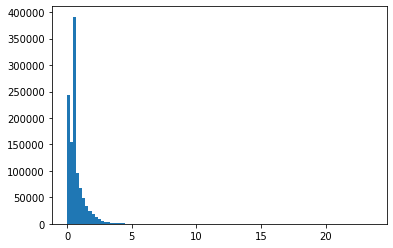

In [27]:
plt.hist(df_all_fill['mb'], bins=100)

In [28]:
skew_col = df_all_fill.apply(lambda x: skew(x)) #смотрим симметричность данных: симметрия = 0 
skew_col.sort_values(ascending=False)

skew_col = skew_col[abs(skew_col) > 0.5] # чем дальше от 0, тем менне симметричные данные.

skew_features = df_all_fill[skew_col.index] # все numeric ячейки с skew_col > 0.5
#skew_features.columns
df_all_fill[skew_features.columns] = np.log1p(df_all_fill[skew_features.columns]) # логарифмируем все skew_col, и target тоже

# df_all_fill[skew_features.columns]
# df_all_fill
# df_all_2['SalePrice'] = np.log1p(df_all_2['SalePrice']) # логарифмируем SalePrice

In [29]:
df_all_fill

,Unnamed: 0,col_n00,col_n01,col_n02,col_n03,col_n04,col_n05,col_n06,col_n07,col_n08,col_n09,col_n10,col_n11,col_n12,col_n13,col_n14,col_n15,col_n16,col_n17,col_n18,col_n19,col_n20,col_n21,col_n22,col_n23,col_n24,col_n25,col_n26,col_n27,col_n28,col_n29,col_n30,col_n31,col_n32,col_n33,col_n34,col_n35,col_n36,col_n37,col_n38,...,col_n47,col_n48,col_n49,col_n50,col_n51,col_n52,col_n53,col_n54,col_n55,col_n56,col_n57,col_n58,col_n59,col_n60,col_n61,col_n62,col_n63,col_n64,col_n65,col_n66,col_n67,col_n68,col_n69,col_n70,col_n71,col_n72,col_n73,col_n74,col_n75,col_n76,col_n77,col_n78,mb,place_id,time_idx,id2_0,id2_2,id2_4,id2_5,id2_6
0,0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.118487,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.027192,0.000000,0.046430,0.0,0.0,0.000000,0.0,0.0,0.0,1.580374,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.029764,0.0,0.0,0.0,0.0,1.580117,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023485,0.0,0.023485,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,1.118706,0.020091,0,8,0.0,0.000000,0.0,1,0.0
1,1,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.974234,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.331321,0.000000,0.046430,0.0,0.0,0.000000,0.0,0.0,0.0,1.276166,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.029764,0.0,0.0,0.0,0.0,1.275932,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023485,0.0,0.023485,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,0.974436,0.581241,0,9,0.0,0.000000,0.0,1,0.0
2,2,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.008137,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333445,0.000000,0.046430,0.0,0.0,0.000000,0.0,0.0,0.0,1.278061,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.029764,0.0,0.0,0.0,0.0,1.277828,0.000000,0.150934,0.0,0.0,0.0,0.000000,0.023485,0.0,0.023485,0.0,0.000000,0.0,0.0,0.151057,0.0,0.000000,0.0,0.0,1.008343,0.561163,0,10,0.0,0.000000,0.0,1,0.0
3,3,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.960236,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.350157,0.000000,0.046430,0.0,0.0,0.000000,0.0,0.0,0.0,1.208869,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.029764,0.0,0.0,0.0,0.0,1.208641,0.000000,0.181121,0.0,0.0,0.0,0.000000,0.023485,0.0,0.023485,0.0,0.000000,0.0,0.0,0.181269,0.0,0.000000,0.0,0.0,0.960437,0.615598,0,11,0.0,0.000000,0.0,1,0.0
4,4,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.023411,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.381833,0.000000,0.046430,0.0,0.0,0.000000,0.0,0.0,0.0,1.233950,0.0,...,0.0,0.0,0.0,0.0,0.261388,0.0,0.0,0.029764,0.0,0.0,0.0,0.0,1.233720,0.000000,0.181121,0.0,0.0,0.0,0.000000,0.023485,0.0,0.023485,0.0,0.000000,0.0,0.0,0.181269,0.0,0.000000,0.0,0.0,1.023619,0.586661,0,12,0.0,0.000000,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,1121935,0.0,0.0,0.0,0.64772,0.23493,0.0,0.058668,0.642634,0.0,0.0,0.0,0.111617,0.0,0.816178,0.0,0.0,0.306079,0.0,0.150887,0.0,0.0,0.163077,0.0,0.0,0.0,0.0,0.0,0.0,0.551523,0.319198,0.304862,0.0,0.0,0.111617,0.0,0.0,0.0,0.735623,0.0,...,0.0,0.0,0.0,0.0,2.400019,0.0,0.0,0.058668,0.0,0.0,0.0,0.0,0.731708,0.040695,0.181121,0.0,0.0,0.0,0.246999,0.090800,0.0,0.000000,0.0,0.060438,0.0,0.0,0.181269,0.0,0.286947,0.0,0.0,0.823268,0.421698,14604,51,0.0,0.000000,0.0,1,0.0
1121936,1121936,0.0,0.0,0.0,0.64772,0.23493,0.0,0.058668,0.642634,0.0,0.0,0.0,0.111617,0.0,0.816178,0.0,0.0,0.306079,0.0,0.150887,0.0,0.0,0.163077,0.0,0.0,0.0,0.0,0.0,0.0,0.551523,0.319198,0.304862,0.0,0.0,0.111617,0.0,0.0,0.0,0.735623,0.0,...,0.0,0.0,0.0,0.0,2.400019,0.0,0.0,0.05

In [30]:
df_all_fill.shape

(1121940, 88)

(array([1.41327e+05, 1.18220e+04, 1.47890e+04, 1.77050e+04, 1.99350e+04,
        2.27920e+04, 2.45160e+04, 2.68470e+04, 2.83270e+04, 2.90560e+04,
        2.94220e+04, 2.95740e+04, 2.91430e+04, 2.90089e+05, 2.81290e+04,
        2.74230e+04, 2.61290e+04, 2.50600e+04, 2.39130e+04, 2.25790e+04,
        2.12470e+04, 2.01180e+04, 1.89420e+04, 1.78270e+04, 1.68270e+04,
        1.53360e+04, 1.43470e+04, 1.32690e+04, 1.22690e+04, 1.15020e+04,
        1.03620e+04, 9.38400e+03, 8.55900e+03, 7.79300e+03, 7.08800e+03,
        6.31600e+03, 5.54800e+03, 5.02300e+03, 4.43000e+03, 3.81300e+03,
        3.32700e+03, 2.80200e+03, 2.44300e+03, 2.12500e+03, 1.95700e+03,
        1.61400e+03, 1.32700e+03, 1.10600e+03, 9.87000e+02, 7.90000e+02,
        6.80000e+02, 5.56000e+02, 4.51000e+02, 4.29000e+02, 3.77000e+02,
        3.00000e+02, 2.59000e+02, 2.38000e+02, 2.00000e+02, 1.62000e+02,
        1.50000e+02, 1.51000e+02, 1.27000e+02, 9.30000e+01, 9.00000e+01,
        7.70000e+01, 6.20000e+01, 5.90000e+01, 5.80

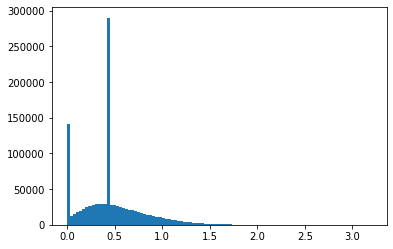

In [31]:
plt.hist(df_all_fill['mb'], bins=100)

In [32]:
df_all_fill['mb'].mode()

0    0.421698
dtype: float64

# StandardScaler

In [33]:
features = df_all_fill.drop(['mb'], axis=1).columns.to_list() # берём все колонки с type=int64&float64 -> удаляем target, для scaler-а остальных фичей
len(features)

87

In [35]:
ss_scaler = StandardScaler()
df_all_fill[features] = ss_scaler.fit_transform(df_all_fill[features]) #итого: scaled_X_tr - фичи, по которым будем учить модель на tr в X_train!
X = df_all_fill[features]

# понижение размерности

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95) # we want the explained variance to be between 95–99%
pca.fit(X)
X_pca = pca.transform(X)

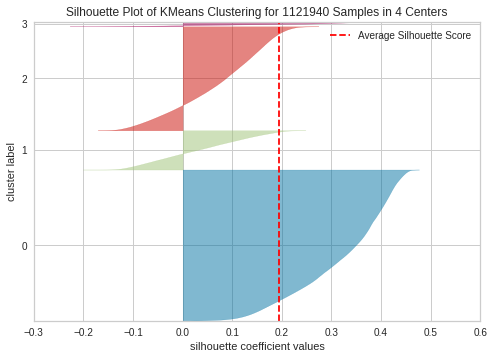

In [100]:
# from yellowbrick.cluster import SilhouetteVisualizer

# model = KMeans(4, random_state=42)
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# visualizer.fit(X_pca)
# visualizer.show()

очень долго.

In [ ]:
# from yellowbrick.cluster import SilhouetteVisualizer

# model = KMeans(10, random_state=42)
# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# visualizer.fit(X_pca)
# visualizer.show()

# кластеризация

In [ ]:
# km = KMeans(6) # или НЕ 4 - выбрать из Силуета
# km.fit(X_pca)

In [ ]:
# op = km.labels_

In [ ]:
# df_all_fill['Class'] = op

# делим на train и test

Train 
Размер таблицы: (860750, 84) : 

индексы строк с 0 по  860749 


Test 
Размер таблицы: (261190, 41) : 

индексы строк с 0 по  261189 

In [36]:
df = df_all_fill.copy()

In [37]:
df_train = df[0:860750]
x_df_train = df[0:860750].drop('mb', axis = 1)  # индексы строк с 0 по 860749 
y_df_train = df['mb'][0:860750]

df_test = df[860750:].drop('mb', axis = 1)   # индексы строк с- все после 860749, БЕЗ таргета

In [40]:
x_train, x_valid, y_train, y_valid = train_test_split(x_df_train, y_df_train.to_numpy(), random_state=42, test_size = 0.2)

# задаём SMAPE

In [41]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true + y_pred + 1e-15))

# baseline

## LinearRegression()

In [42]:
lr = LinearRegression()
       
lr.fit(x_train, y_train)
train_smape_lr = smape(np.expm1(y_train), np.expm1(lr.predict(x_train)))
valid_smape_lr = smape(np.expm1(y_valid), np.expm1(lr.predict (x_valid)))

print("train smape:", train_smape_lr)
print("test smape:", valid_smape_lr)

train smape: 0.3889223505679647
test smape: 0.3741137991730892


## LassoCV()

In [44]:
lasso = LassoCV(alphas=np.arange(0.0001, 3, 0.1))

lasso.fit(x_train, y_train)
train_smape_lasso = smape(np.expm1(y_train), np.expm1(lasso.predict(x_train)))
valid_smape_lasso = smape(np.expm1(y_valid), np.expm1(lasso.predict (x_valid)))

print("train smape:", train_smape_lasso)
print("test smape:", valid_smape_lasso)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16691.33077871883, tolerance: 7.584446413898085
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16700.77352438592, tolerance: 7.594667215817495
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16690.18465044758, tolerance: 7.594808749424364
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16644.556533

train smape: 0.37788332268562175
test smape: 0.37378318603518024


## RidgeCV()

In [46]:
ridge = RidgeCV(alphas=np.arange(0.001, 3, 0.1))

ridge.fit(x_train, y_train)
train_smape_ridge = smape(np.expm1(y_train), np.expm1(ridge.predict(x_train)))
valid_smape_ridge = smape(np.expm1(y_valid), np.expm1(ridge.predict (x_valid)))

print("train smape:", train_smape_ridge)
print("test smape:", valid_smape_ridge)

train smape: 8.920089665411664
test smape: 8.508392385287802


# модели серьёзнее

## GradientBoostingRegressor()

In [42]:
gbr = GradientBoostingRegressor(max_depth=3, learning_rate = 0.05, n_estimators=250) 

gbr.fit(x_train, y_train)
train_smape_gbr = smape(np.expm1(y_train), np.expm1(gbr.predict(x_train)))
valid_smape_gbr = smape(np.expm1(y_valid), np.expm1(gbr.predict (x_valid)))

print("train smape:", train_smape_gbr)
print("test smape:", valid_smape_gbr)

train smape: 0.3395922289983112
test smape: 0.3397219473502614


## XGBRegressor()

In [43]:
xgbr = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=200)

xgbr.fit(x_train, y_train)
train_smape_xgbr = smape(np.expm1(y_train), np.expm1(xgbr.predict(x_train)))
valid_smape_xgbr = smape(np.expm1(y_valid), np.expm1(xgbr.predict (x_valid)))

print("train smape:", train_smape_xgbr)
print("test smape:", valid_smape_xgbr)

[12:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train smape: 0.33740671382766385
test smape: 0.33529547225681144


# попробуем Grid Search?

очень долго, больше 3ч...

In [ ]:
xgbr_example = XGBRegressor()

params_xgbr = {'max_depth': [2, 5, 10], #задать сначала [2, 5, 10] -> потом (i for i in range [..., ...])
                'learning_rate': [0.1, 0.05], #задать сначала [0.1, 0.05] -> потом что-то одно
                'n_estimators': [100, 200, 300] } #задать сначала [100, 200, 300]  -> потом (i for i in range [..., ...])

Grid_Search_xgbr = GridSearchCV(xgbr_example, 
                                param_grid=params_xgbr,
                                scoring='neg_mean_squared_error') 
Grid_Search_xgbr.fit(x_train, y_train)

GS_xgbr_best_params = Grid_Search_xgbr.best_params_
GS_xgbr_best_params

# ИТОГ

меньшую ошибку показал xgbr - его используем для предикта на test

In [44]:
result= np.expm1(xgbr.predict(df_test))

In [45]:
result

array([0.6562356 , 0.6562356 , 0.61687714, ..., 0.77264124, 0.5453971 ,
       0.77264124], dtype=float32)